In [1]:
import numpy as np
import os
import cv2

import torch
from torchvision import transforms
import matplotlib.pyplot as plt

from PIL import Image

c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

train_images = np.load(os.path.join(data_src_folder, 'train_images.npy'))
train_labels = np.load(os.path.join(data_src_folder, 'train_labels.npy'))

val_images = np.load(os.path.join(data_src_folder, 'val_images.npy'))
val_labels = np.load(os.path.join(data_src_folder, 'val_labels.npy'))

test_images = np.load(os.path.join(data_src_folder, 'test_images.npy'))
test_labels = np.load(os.path.join(data_src_folder, 'test_labels.npy'))

print(f"train_images shape: {train_images.shape}, train_labels shape: {train_labels.shape}")
print(f"train_images shape: {val_images.shape}, train_labels shape: {val_labels.shape}")
print(f"train_images shape: {test_images.shape}, train_labels shape: {test_labels.shape}")

train_images shape: (28389, 48, 48), train_labels shape: (28389, 8)
train_images shape: (3546, 48, 48), train_labels shape: (3546, 8)
train_images shape: (3553, 48, 48), train_labels shape: (3553, 8)


In [3]:
from torch.utils.data import Dataset, DataLoader
class FERP_PreDataset(Dataset):
  def __init__(self, x_face, y_lab, transform):
    super(FERP_PreDataset,self).__init__()
    self.x_face = x_face
    self.y_lab = y_lab
    self.transform = transform 

  def __len__(self):
    return len(self.y_lab)
  
  def __getitem__(self, index):
    image_face = self.x_face[index]
    label = self.y_lab[index]
    
    image_face = np.array(image_face, dtype=np.uint8)
    image_face = cv2.cvtColor(image_face, cv2.COLOR_GRAY2RGB)

    return self.transform(image_face), torch.tensor(label, dtype=torch.float32)

In [4]:
batch_size = 32

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((224, 224))])

train_dataset = FERP_PreDataset(train_images, train_labels, \
                                  train_transform)
val_dataset = FERP_PreDataset(val_images, val_labels, \
                                test_transform)
test_dataset = FERP_PreDataset(test_images, test_labels, \
                                 test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))

train loader  887 val loader  111 test 112


In [5]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

model_path_local = 'C:\\BME\\7_felev\\szakdoli\\models\\mediapipe\\face_landmarker_v2_with_blendshapes.task'

base_options = python.BaseOptions(model_asset_path=model_path_local)
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                        output_face_blendshapes=True,
                                        output_facial_transformation_matrixes=True,
                                        num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

In [6]:
# Copyright 2020 The MediaPipe Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""MediaPipe solution drawing utils."""

import dataclasses
import math
from typing import List, Mapping, Optional, Tuple, Union

import cv2
import matplotlib.pyplot as plt
import numpy as np

from mediapipe.framework.formats import detection_pb2
from mediapipe.framework.formats import landmark_pb2
from mediapipe.framework.formats import location_data_pb2

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5
_BGR_CHANNELS = 3

WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)
GREEN_COLOR = (0, 128, 0)
BLUE_COLOR = (255, 0, 0)


@dataclasses.dataclass
class DrawingSpec:
  # Color for drawing the annotation. Default to the white color.
  color: Tuple[int, int, int] = WHITE_COLOR
  # Thickness for drawing the annotation. Default to 2 pixels.
  thickness: int = 2
  # Circle radius. Default to 2 pixels.
  circle_radius: int = 2


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def draw_detection(
    image: np.ndarray,
    detection: detection_pb2.Detection,
    keypoint_drawing_spec: DrawingSpec = DrawingSpec(color=RED_COLOR),
    bbox_drawing_spec: DrawingSpec = DrawingSpec()):
  """Draws the detction bounding box and keypoints on the image.

  Args:
    image: A three channel BGR image represented as numpy ndarray.
    detection: A detection proto message to be annotated on the image.
    keypoint_drawing_spec: A DrawingSpec object that specifies the keypoints'
      drawing settings such as color, line thickness, and circle radius.
    bbox_drawing_spec: A DrawingSpec object that specifies the bounding box's
      drawing settings such as color and line thickness.

  Raises:
    ValueError: If one of the followings:
      a) If the input image is not three channel BGR.
      b) If the location data is not relative data.
  """
  if not detection.location_data:
    return
  if image.shape[2] != _BGR_CHANNELS:
    raise ValueError('Input image must contain three channel bgr data.')
  image_rows, image_cols, _ = image.shape

  location = detection.location_data
  if location.format != location_data_pb2.LocationData.RELATIVE_BOUNDING_BOX:
    raise ValueError(
        'LocationData must be relative for this drawing funtion to work.')
  # Draws keypoints.
  for keypoint in location.relative_keypoints:
    keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                   image_cols, image_rows)
    cv2.circle(image, keypoint_px, keypoint_drawing_spec.circle_radius,
               keypoint_drawing_spec.color, keypoint_drawing_spec.thickness)
  # Draws bounding box if exists.
  if not location.HasField('relative_bounding_box'):
    return
  relative_bounding_box = location.relative_bounding_box
  rect_start_point = _normalized_to_pixel_coordinates(
      relative_bounding_box.xmin, relative_bounding_box.ymin, image_cols,
      image_rows)
  rect_end_point = _normalized_to_pixel_coordinates(
      relative_bounding_box.xmin + relative_bounding_box.width,
      relative_bounding_box.ymin + relative_bounding_box.height, image_cols,
      image_rows)
  cv2.rectangle(image, rect_start_point, rect_end_point,
                bbox_drawing_spec.color, bbox_drawing_spec.thickness)


def draw_landmarks(
    image: np.ndarray,
    landmark_list: landmark_pb2.NormalizedLandmarkList,
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Union[DrawingSpec,
                                 Mapping[int, DrawingSpec]] = DrawingSpec(
                                     color=RED_COLOR),
    connection_drawing_spec: Union[DrawingSpec,
                                   Mapping[Tuple[int, int],
                                           DrawingSpec]] = DrawingSpec(),
    is_drawing_landmarks: bool = True,
    idx_to_coords_param = None):
  """Draws the landmarks and the connections on the image.

  Args:
    image: A three channel BGR image represented as numpy ndarray.
    landmark_list: A normalized landmark list proto message to be annotated on
      the image.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected in the drawing.
    landmark_drawing_spec: Either a DrawingSpec object or a mapping from hand
      landmarks to the DrawingSpecs that specifies the landmarks' drawing
      settings such as color, line thickness, and circle radius. If this
      argument is explicitly set to None, no landmarks will be drawn.
    connection_drawing_spec: Either a DrawingSpec object or a mapping from hand
      connections to the DrawingSpecs that specifies the connections' drawing
      settings such as color and line thickness. If this argument is explicitly
      set to None, no landmark connections will be drawn.
    is_drawing_landmarks: Whether to draw landmarks. If set false, skip drawing
      landmarks, only contours will be drawed.

  Raises:
    ValueError: If one of the followings:
      a) If the input image is not three channel BGR.
      b) If any connetions contain invalid landmark index.
  """
  if not landmark_list:
    return
  if image.shape[2] != _BGR_CHANNELS:
    raise ValueError('Input image must contain three channel bgr data.')
  image_rows, image_cols, _ = image.shape
  idx_to_coordinates = {}
  for idx, landmark in enumerate(landmark_list.landmark):
    if ((landmark.HasField('visibility') and
         landmark.visibility < _VISIBILITY_THRESHOLD) or
        (landmark.HasField('presence') and
         landmark.presence < _PRESENCE_THRESHOLD)):
      continue
    landmark_px = _normalized_to_pixel_coordinates(landmark.x, landmark.y,
                                                   image_cols, image_rows)
    if landmark_px:
      idx_to_coordinates[idx] = landmark_px
  
  if idx_to_coords_param != None:
    idx_to_coordinates = idx_to_coords_param
  
  if connections:
    num_landmarks = len(landmark_list.landmark)
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
        drawing_spec = connection_drawing_spec[connection] if isinstance(
            connection_drawing_spec, Mapping) else connection_drawing_spec
        cv2.line(image, idx_to_coordinates[start_idx],
                 idx_to_coordinates[end_idx], drawing_spec.color,
                 drawing_spec.thickness)
  # Draws landmark points after finishing the connection lines, which is
  # aesthetically better.
  if is_drawing_landmarks and landmark_drawing_spec:
    for idx, landmark_px in idx_to_coordinates.items():
      drawing_spec = landmark_drawing_spec[idx] if isinstance(
          landmark_drawing_spec, Mapping) else landmark_drawing_spec
      # White circle border
      circle_border_radius = max(drawing_spec.circle_radius + 1,
                                 int(drawing_spec.circle_radius * 1.2))
      cv2.circle(image, landmark_px, circle_border_radius, WHITE_COLOR,
                 drawing_spec.thickness)
      # Fill color into the circle
      cv2.circle(image, landmark_px, drawing_spec.circle_radius,
                 drawing_spec.color, drawing_spec.thickness)


def draw_landmarks_grayscale(
    image: np.ndarray,
    landmark_list: landmark_pb2.NormalizedLandmarkList,
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Union[DrawingSpec,
                                 Mapping[int, DrawingSpec]] = DrawingSpec(
                                     color=255),  # Use white (max value in grayscale)
    connection_drawing_spec: Union[DrawingSpec,
                                   Mapping[Tuple[int, int],
                                           DrawingSpec]] = DrawingSpec(color=255),
    is_drawing_landmarks: bool = True):
  """Draws the landmarks and the connections on a grayscale image.

  Args:
    image: A single-channel grayscale image represented as numpy ndarray.
    landmark_list: A normalized landmark list proto message to be annotated on
      the image.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected in the drawing.
    landmark_drawing_spec: Either a DrawingSpec object or a mapping from landmarks
      to the DrawingSpecs that specifies the landmarks' drawing settings such as
      color, line thickness, and circle radius. If this argument is explicitly set
      to None, no landmarks will be drawn.
    connection_drawing_spec: Either a DrawingSpec object or a mapping from landmark
      connections to the DrawingSpecs that specifies the connections' drawing
      settings such as color and line thickness. If this argument is explicitly set
      to None, no landmark connections will be drawn.
    is_drawing_landmarks: Whether to draw landmarks. If set false, skip drawing
      landmarks, only connections will be drawn.

  Raises:
    ValueError: If the input image is not a single-channel grayscale image.
  """
  if not landmark_list:
    return
  image_rows = 224
  image_cols = 224
  idx_to_coordinates = {}
  for idx, landmark in enumerate(landmark_list.landmark):
    if ((landmark.HasField('visibility') and
         landmark.visibility < _VISIBILITY_THRESHOLD) or
        (landmark.HasField('presence') and
         landmark.presence < _PRESENCE_THRESHOLD)):
      continue
    landmark_px = _normalized_to_pixel_coordinates(landmark.x, landmark.y,
                                                   image_cols, image_rows)
    if landmark_px:
      idx_to_coordinates[idx] = landmark_px
  if connections:
    num_landmarks = len(landmark_list.landmark)
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
        drawing_spec = connection_drawing_spec[connection] if isinstance(
            connection_drawing_spec, Mapping) else connection_drawing_spec
        cv2.line(image, idx_to_coordinates[start_idx],
                 idx_to_coordinates[end_idx], drawing_spec.color,
                 drawing_spec.thickness)
  # Draws landmark points after finishing the connection lines, which is
  # aesthetically better.
  if is_drawing_landmarks and landmark_drawing_spec:
    for idx, landmark_px in idx_to_coordinates.items():
      drawing_spec = landmark_drawing_spec[idx] if isinstance(
          landmark_drawing_spec, Mapping) else landmark_drawing_spec
      # White circle border (use max value 255 for grayscale)
      circle_border_radius = max(drawing_spec.circle_radius + 1,
                                 int(drawing_spec.circle_radius * 1.2))
      cv2.circle(image, landmark_px, circle_border_radius, 255,  # White color
                 drawing_spec.thickness)
      # Fill the circle with the landmark color
      cv2.circle(image, landmark_px, drawing_spec.circle_radius,
                 drawing_spec.color, drawing_spec.thickness)


def draw_axis(image: np.ndarray,
              rotation: np.ndarray,
              translation: np.ndarray,
              focal_length: Tuple[float, float] = (1.0, 1.0),
              principal_point: Tuple[float, float] = (0.0, 0.0),
              axis_length: float = 0.1,
              axis_drawing_spec: DrawingSpec = DrawingSpec()):
  """Draws the 3D axis on the image.

  Args:
    image: A three channel BGR image represented as numpy ndarray.
    rotation: Rotation matrix from object to camera coordinate frame.
    translation: Translation vector from object to camera coordinate frame.
    focal_length: camera focal length along x and y directions.
    principal_point: camera principal point in x and y.
    axis_length: length of the axis in the drawing.
    axis_drawing_spec: A DrawingSpec object that specifies the xyz axis drawing
      settings such as line thickness.

  Raises:
    ValueError: If one of the followings:
      a) If the input image is not three channel BGR.
  """
  if image.shape[2] != _BGR_CHANNELS:
    raise ValueError('Input image must contain three channel bgr data.')
  image_rows, image_cols, _ = image.shape
  # Create axis points in camera coordinate frame.
  axis_world = np.float32([[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]])
  axis_cam = np.matmul(rotation, axis_length * axis_world.T).T + translation
  x = axis_cam[..., 0]
  y = axis_cam[..., 1]
  z = axis_cam[..., 2]
  # Project 3D points to NDC space.
  fx, fy = focal_length
  px, py = principal_point
  x_ndc = np.clip(-fx * x / (z + 1e-5) + px, -1., 1.)
  y_ndc = np.clip(-fy * y / (z + 1e-5) + py, -1., 1.)
  # Convert from NDC space to image space.
  x_im = np.int32((1 + x_ndc) * 0.5 * image_cols)
  y_im = np.int32((1 - y_ndc) * 0.5 * image_rows)
  # Draw xyz axis on the image.
  origin = (x_im[0], y_im[0])
  x_axis = (x_im[1], y_im[1])
  y_axis = (x_im[2], y_im[2])
  z_axis = (x_im[3], y_im[3])
  cv2.arrowedLine(image, origin, x_axis, RED_COLOR, axis_drawing_spec.thickness)
  cv2.arrowedLine(image, origin, y_axis, GREEN_COLOR,
                  axis_drawing_spec.thickness)
  cv2.arrowedLine(image, origin, z_axis, BLUE_COLOR,
                  axis_drawing_spec.thickness)


def _normalize_color(color):
  return tuple(v / 255. for v in color)


def plot_landmarks(landmark_list: landmark_pb2.NormalizedLandmarkList,
                   connections: Optional[List[Tuple[int, int]]] = None,
                   landmark_drawing_spec: DrawingSpec = DrawingSpec(
                       color=RED_COLOR, thickness=5),
                   connection_drawing_spec: DrawingSpec = DrawingSpec(
                       color=BLACK_COLOR, thickness=5),
                   elevation: int = 10,
                   azimuth: int = 10):
  """Plot the landmarks and the connections in matplotlib 3d.

  Args:
    landmark_list: A normalized landmark list proto message to be plotted.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected.
    landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
      drawing settings such as color and line thickness.
    connection_drawing_spec: A DrawingSpec object that specifies the
      connections' drawing settings such as color and line thickness.
    elevation: The elevation from which to view the plot.
    azimuth: the azimuth angle to rotate the plot.

  Raises:
    ValueError: If any connection contains an invalid landmark index.
  """
  if not landmark_list:
    return
  plt.figure(figsize=(10, 10))
  ax = plt.axes(projection='3d')
  ax.view_init(elev=elevation, azim=azimuth)
  plotted_landmarks = {}
  for idx, landmark in enumerate(landmark_list.landmark):
    if ((landmark.HasField('visibility') and
         landmark.visibility < _VISIBILITY_THRESHOLD) or
        (landmark.HasField('presence') and
         landmark.presence < _PRESENCE_THRESHOLD)):
      continue
    ax.scatter3D(
        xs=[-landmark.z],
        ys=[landmark.x],
        zs=[-landmark.y],
        color=_normalize_color(landmark_drawing_spec.color[::-1]),
        linewidth=landmark_drawing_spec.thickness)
    plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
  if connections:
    num_landmarks = len(landmark_list.landmark)
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
        landmark_pair = [
            plotted_landmarks[start_idx], plotted_landmarks[end_idx]
        ]
        ax.plot3D(
            xs=[landmark_pair[0][0], landmark_pair[1][0]],
            ys=[landmark_pair[0][1], landmark_pair[1][1]],
            zs=[landmark_pair[0][2], landmark_pair[1][2]],
            color=_normalize_color(connection_drawing_spec.color[::-1]),
            linewidth=connection_drawing_spec.thickness)
  plt.show()


In [7]:
# Visualization code by google
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2


def draw_landmarks_on_image(rgb_image, detection_result, idx_to_coordinates_avg_mask):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style(),
        idx_to_coords_param = idx_to_coordinates_avg_mask)
    draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style(),
        idx_to_coords_param = idx_to_coordinates_avg_mask)
    draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style(),
        idx_to_coords_param = idx_to_coordinates_avg_mask)

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

(478, 2)
{0: (113, 146), 1: (112, 120), 2: (112, 128), 3: (105, 94), 4: (112, 112), 5: (112, 102), 6: (112, 75), 7: (57, 70), 8: (112, 53), 9: (112, 42), 10: (112, 2), 11: (113, 149), 12: (113, 152), 13: (113, 154), 14: (113, 166), 15: (113, 169), 16: (113, 173), 17: (113, 177), 18: (113, 182), 19: (112, 124), 20: (105, 124), 21: (30, 33), 22: (79, 76), 23: (72, 77), 24: (64, 77), 25: (54, 72), 26: (86, 75), 27: (66, 52), 28: (76, 54), 29: (58, 54), 30: (53, 57), 31: (48, 77), 32: (84, 189), 33: (55, 67), 34: (27, 69), 35: (39, 70), 36: (73, 111), 37: (103, 145), 38: (104, 151), 39: (93, 147), 40: (86, 150), 41: (96, 152), 42: (90, 153), 43: (75, 162), 44: (106, 120), 45: (105, 112), 46: (43, 50), 47: (89, 91), 48: (89, 116), 49: (89, 112), 50: (50, 109), 51: (105, 102), 52: (60, 43), 53: (50, 45), 54: (37, 20), 55: (95, 52), 56: (84, 58), 57: (70, 154), 58: (36, 145), 59: (95, 121), 60: (100, 124), 61: (79, 156), 62: (81, 156), 63: (46, 39), 64: (89, 120), 65: (75, 45), 66: (73, 37), 

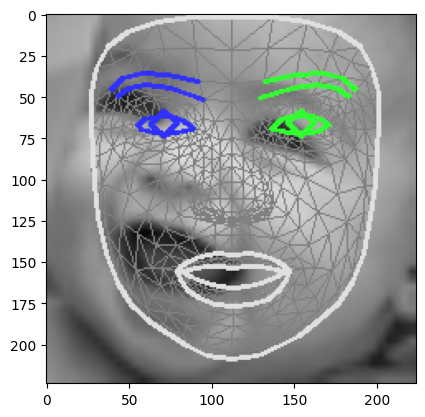

In [9]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

average_2d_mask = np.load(os.path.join(data_src_folder, "average_mask.npy"))

print(average_2d_mask.shape)

idx_to_coordinates_avg_mask = {i: (round(average_2d_mask[i][0]), round(average_2d_mask[i][1])) for i in range(average_2d_mask.shape[0])}
print(idx_to_coordinates_avg_mask)

# run face detector for one image and plot result
# 675 is good! for basic face mask
i = 86
image, label = test_dataset[i]
print(label)

image = np.array(image, dtype=np.uint8)
print(image.shape)

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
detection_result = detector.detect(mp_image)
annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result, idx_to_coordinates_avg_mask)

print(len(detection_result.face_landmarks[0]))
plt.imshow(annotated_image)
plt.show()
# plt.imshow(image)
# plt.show()

(478, 2)
{0: (132, 149), 1: (114, 121), 2: (124, 133), 3: (108, 98), 4: (112, 112), 5: (113, 103), 6: (118, 79), 7: (66, 92), 8: (116, 54), 9: (114, 42), 10: (111, 2), 11: (132, 152), 12: (135, 154), 13: (136, 156), 14: (155, 191), 15: (157, 195), 16: (157, 198), 17: (157, 203), 18: (154, 211), 19: (118, 127), 20: (114, 130), 21: (46, 67), 22: (88, 94), 23: (81, 97), 24: (72, 98), 25: (63, 96), 26: (95, 91), 27: (71, 68), 28: (81, 67), 29: (63, 72), 30: (58, 78), 31: (58, 103), 32: (117, 224), 33: (64, 91), 34: (48, 106), 35: (51, 98), 36: (83, 130), 37: (119, 150), 38: (124, 157), 39: (110, 156), 40: (107, 162), 41: (116, 160), 42: (111, 163), 43: (103, 188), 44: (107, 123), 45: (104, 114), 46: (48, 71), 47: (99, 104), 48: (96, 127), 49: (95, 122), 50: (58, 137), 51: (105, 105), 52: (61, 55), 53: (51, 62), 54: (46, 48), 55: (97, 57), 56: (91, 71), 57: (94, 177), 58: (84, 189), 59: (105, 131), 60: (111, 131), 61: (108, 172), 62: (111, 172), 63: (48, 58), 64: (99, 131), 65: (75, 54), 66

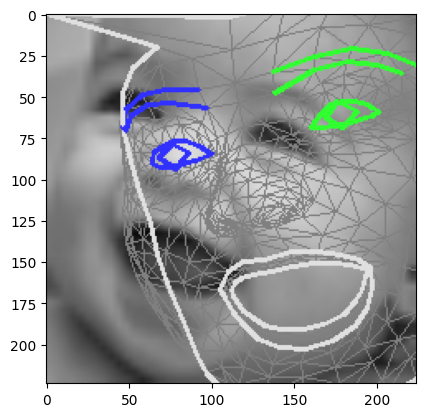

In [ ]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\transformed_masks"
i = 86
average_2d_mask = np.load(os.path.join(data_src_folder, f"transformed_mask_{i}.npy"))

print(average_2d_mask.shape)

idx_to_coordinates_avg_mask = {i: (round(average_2d_mask[i][0]), round(average_2d_mask[i][1])) for i in range(average_2d_mask.shape[0])}
print(idx_to_coordinates_avg_mask)

image, label = test_dataset[i]
print(label)

image = np.array(image, dtype=np.uint8)
print(image.shape)

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
detection_result = detector.detect(mp_image)
annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result, idx_to_coordinates_avg_mask)

print(len(detection_result.face_landmarks[0]))
plt.imshow(annotated_image)
plt.show()
# plt.imshow(image)
# plt.show()